## Autoencoder
From https://www.tensorflow.org/tutorials/generative/autoencoder

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [10]:
latent_dim = 64

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28))
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [12]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0397 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0123 - val_loss: 0.0107
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0104 - val_loss: 0.0104
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.008

In [13]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

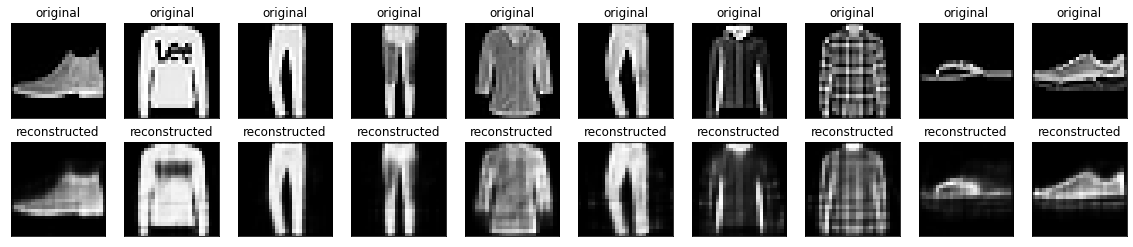

In [14]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Normalizing Flow
From https://www.tensorflow.org/probability/api_docs/python/tfp/layers/AutoregressiveTransform

In [15]:
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors
tfk = tf.keras

In [112]:
encoded_imgs = autoencoder.encoder(x_train).numpy()

60000

In [165]:
n = len(encoded_imgs)

# Density estimation with MADE.
model = tfk.Sequential([
    tfk.layers.InputLayer(input_shape=(0,), dtype=tf.float32),
    tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
        loc=tf.zeros(tf.concat([tf.shape(t)[:-1], [64]], axis=0)),
        scale_diag=tf.ones(64))),
    tfpl.AutoregressiveTransform(tfb.AutoregressiveNetwork(
        params=2, hidden_units=[10], activation='relu')),
])

model.compile(optimizer='adam', loss=lambda y, rv_y: -rv_y.log_prob(y))

model.fit(x=np.zeros((n, 0)),
          y=encoded_imgs,
          epochs=100,
          shuffle=True,
          verbose=True)


Epoch 1/100
1875/1875 [==============================] - 10s 5ms/step - loss: 151.3271
Epoch 2/100
1875/1875 [==============================] - 5s 3ms/step - loss: 99.1906
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 95.5160
Epoch 4/100
1875/1875 [==============================] - 5s 3ms/step - loss: 94.8021
Epoch 5/100
1875/1875 [==============================] - 5s 3ms/step - loss: 93.3835
Epoch 6/100
1875/1875 [==============================] - 8s 4ms/step - loss: 92.2812
Epoch 7/100
1875/1875 [==============================] - 6s 3ms/step - loss: 92.2601
Epoch 8/100
1875/1875 [==============================] - 7s 4ms/step - loss: 92.0033
Epoch 9/100
1875/1875 [==============================] - 8s 4ms/step - loss: 91.6444
Epoch 10/100
1875/1875 [==============================] - 6s 3ms/step - loss: 93.3956
Epoch 11/100
1875/1875 [==============================] - 6s 3ms/step - loss: 91.0715
Epoch 12/100
1875/1875 [==============================] - 6s 

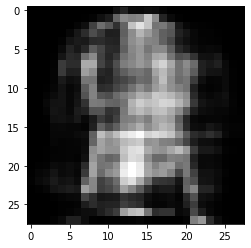

In [196]:
distribution=model(np.zeros(0,))
test_img = distribution.sample(1)
plt.imshow(autoencoder.decoder(test_img)[0])